<a href="https://colab.research.google.com/github/davidalvarez03/Polynomials/blob/main/David2degreepolynomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# some python imports
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from astropy.io import fits

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.11.5-py3-none-any.whl size=1139060 sha256=99539d1d0e8e7efd01d8ec0801590adce56c8402ff146d4bc96bfc1f843e1558
  Stored in directory: /root/.cache/pip/wheels/78/dd/d9/bbdd80cec79b57ec559b7183476b0e8802a2c029e312d05b0f
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15729 sha256=a5b848dc1a7354af6f8446da0e49682b3fe238b6ea6092fc5f81b5f320e245f1
  Stored in directory: /root/.cache/pip/wheels/4a/ea/3e/b79646d96eaea54

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/Shareddrives/Finding Lenses Team Drive/Projects/Lens_Modeling/gigalens/gigalens" ./
!cp -r "/content/drive/Shareddrives/Finding Lenses Team Drive/Projects/Lens_Modeling/gigalens/assets" ./

import gigalens

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from corner import corner
from scipy.stats import norm

from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import epl, shear, sie

tfd = tfp.distributions

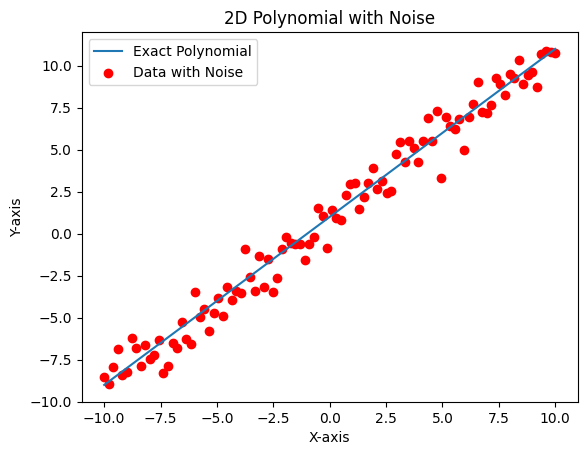

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define the coefficients of the polynomial
true_coefficients = [1, 1]  # Adjust as needed for your polynomial

# Define the range of x values
x_values = np.linspace(-10, 10, 100)

# Generate y values based on the polynomial equation
y_values_exact = np.polyval(true_coefficients, x_values)

# Add noise to the y values
sigma=1 #noise
noise = np.random.normal(0, sigma, len(x_values))  # Adjust the parameters as needed
y_values_with_noise = y_values_exact + noise
data=[x_values,y_values_with_noise]
data=np.array(data)
# Plot the exact polynomial and the data points with noise
plt.plot(x_values, y_values_exact, label='Exact Polynomial')
plt.scatter(x_values, y_values_with_noise, c='red', label='Data with Noise')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Polynomial with Noise')
plt.show()


In [ ]:
#defining the prior
#DEFINING THE PRIOR, LIKELIHOOD AND POSTERIOR

def gaussian(x, mu, sigma):
    exponent = -((x - mu)**2) / (2 * sigma**2)
    prefactor = 1 / (np.sqrt(2 * np.pi) * sigma)
    return prefactor * np.exp(exponent)

def logprior(coefficients):
    lin_coef, ind_coef = coefficients
    p_lin_coef=gaussian(lin_coef,0.0, 15)
    p_ind_coef=gaussian(ind_coef,0.0,15)
    return np.log(p_lin_coef*p_ind_coef)

def loglikelihood(coefficients,data):
    x_values=data[0,:]
    y_values=data[1,:]
    lin_coef, ind_coef = coefficients
    a=[]
    for i in range(len(x_values)):
      a.append(gaussian(np.polyval(coefficients,x_values[i]),y_values[i],sigma))
    a=np.array(a)
    return np.sum(np.log(a))

def logposterior(coefficients,data):
  return logprior(coefficients)+loglikelihood(coefficients,data)



In [ ]:
#WE WILL USE GRADIENT DESCENT TO CALCULATE DE MAXIMUM A POSTERIORI

def gradient(f, coefs, delta):
    '''Computes the finite difference gradient of the function f at parameters 'coefs' with stepsize delta.'''
    g=[]
    for i in range(len(coefs)):
       coefs1=np.zeros(len(coefs))
       coefs1[i]=1
       g.append(((f(np.array(coefs)+delta*np.array(coefs1)))-f(coefs))/(delta))

    return g

def gradient_descent(f, coefs_0, lam, delta, numiter):
    '''
    Runs the gradient descent algorithm to optimize the function f starting at parameters phi0, with
    learning rate lam, finite difference stepsize delta, for numiter iterations, outputting the
    parameters found at each iteration.
    '''
    b=len(coefs_0)
    gd=np.zeros([numiter,b])
    gd[0,:]=coefs_0
    i=0
    while i<numiter-1:
          i=i+1
          gd[i,:]=gd[i-1,:]-lam*np.array(gradient(f, coefs_0, delta))
          coefs_0=np.array(coefs_0)-lam*np.array(gradient(f, coefs_0, delta))

    return gd





[1.00689482 0.89611318]


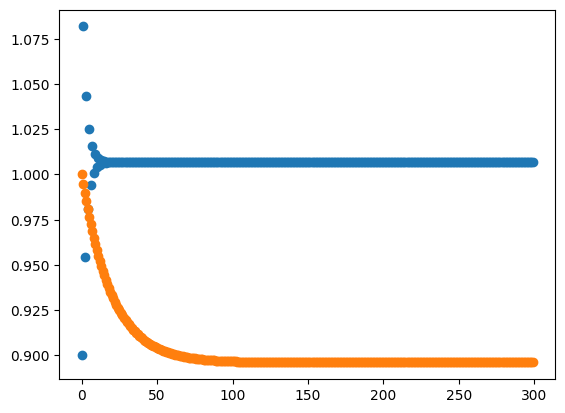

In [ ]:
# Define inputs to the gradient descent function
coefs0 = [0.9,1]
lam = [0.0005,0.0005]
delta = 1e-6
numiter = 300
data = data

# Run gradient descent function
# Hint: try using an anonymous function with the lambda keyword
MAP = gradient_descent(lambda coefs0: -1*logposterior(coefs0,data), coefs0, lam, delta, numiter)
plt.plot(range(len(MAP)),MAP,'o')
MAP_coefficients = MAP[-1]
print(MAP_coefficients)

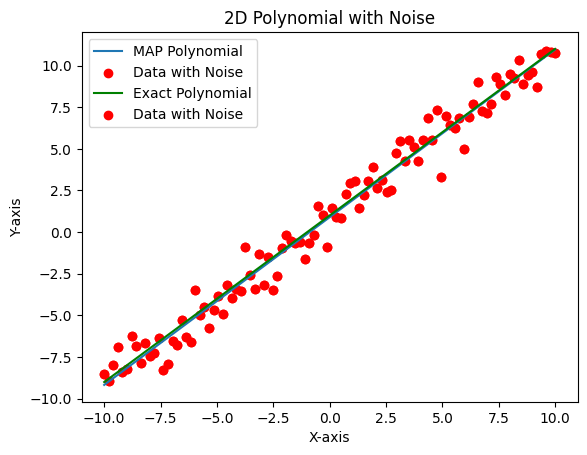

In [ ]:
y_values_MAP = np.polyval(MAP_coefficients, x_values)
plt.plot(x_values, y_values_MAP, label='MAP Polynomial')
plt.scatter(x_values, y_values_with_noise, c='red', label='Data with Noise')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Polynomial with Noise')
plt.plot(x_values, y_values_exact, c='g',label='Exact Polynomial')
plt.scatter(x_values, y_values_with_noise, c='red', label='Data with Noise')
plt.legend()
plt.show()